In [ ]:
# rsync --dry-run -aLvz --include "[0-9][0-9][0-9][0-9]/" \
# --include "apStar*.fits" --exclude "*"\
# --prune-empty-dirs --progress \
# rsync:/https://data.sdss.org/sas/dr14/apogee/spectro/redux/r8/stars/apo25m/
# import apogee.tools.read as apread
# from apogee.tools import path

In [ ]:
# !ls /data/jdli/sdss/data_Hogg18_wise_gdr3.fits

In [122]:
%matplotlib inline
%load_ext autoreload
%autoreload 2
from pylab import *
import os
os.environ["SDSS_LOCAL_SAS_MIRROR"]="/data/jdli/sdss/"

from astropy.table import Table
from tqdm import tqdm
import numpy as np

try:
    import fitsio
    fitsread= fitsio.read
    fitswrite=fitsio.write
    headerread=fitsio.read_header
    _FITSIO_LOADED = True
    
except ImportError:
    import astropy.io.fits as pyfits
    fitsread= pyfits.getdata
    fitswrite=pyfits.writeto
    headerread=pyfits.getheader
    _FITSIO_LOADED = False

cat = Table.read(os.environ["SDSS_LOCAL_SAS_MIRROR"]+"data_Hogg18_wise.fits")
df = cat.to_pandas()

print(df.shape, df.columns)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
(44783, 49) Index(['2MASS_ID', 'Gaia_parallax', 'Gaia_parallax_err', 'spec_parallax',
       'spec_parallax_err', 'training_set', 'sample', 'APOGEE_ID', 'TELESCOPE',
       'LOCATION_ID', 'FIELD', 'J', 'J_ERR', 'H', 'H_ERR', 'K', 'K_ERR', 'RA',
       'DEC', 'GLON', 'GLAT', 'SNR', 'VHELIO_AVG', 'VSCATTER', 'VERR',
       'VERR_MED', 'TEFF', 'TEFF_ERR', 'LOGG', 'LOGG_ERR', 'M_H', 'M_H_ERR',
       'ALPHA_M', 'ALPHA_M_ERR', 'AK_WISE', 'W1mag', 'W2mag', 'W3mag', 'W4mag',
       'Jmag', 'Hmag', 'Kmag', 'e_W1mag', 'e_W2mag', 'e_W3mag', 'e_W4mag',
       'e_Jmag', 'e_Hmag', 'e_Kmag'],
      dtype='object')


(44783, 49)
(41671, 49)


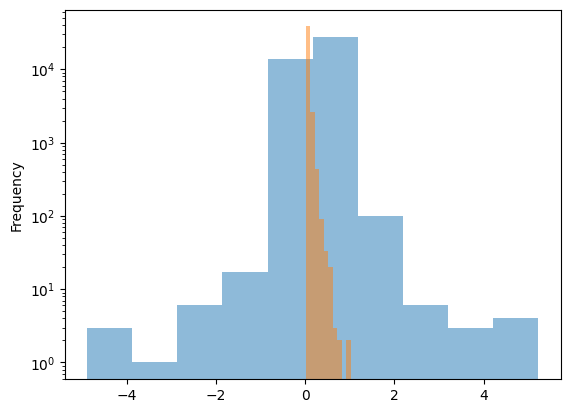

In [123]:
print(df.shape)

ind = (df['M_H']>-3.) & (df['M_H']<0.5) &\
        (df['VSCATTER']<1.)

df['Gaia_parallax'][ind].plot(kind='hist', alpha=0.5, log=True);
df['Gaia_parallax_err'][ind].plot(kind='hist', alpha=0.5, log=True);


gdf = df[ind].copy()

print(gdf.shape)

In [2]:
from astroNN.apogee import visit_spectra, apogee_continuum
from astropy.io import fits
from tqdm import tqdm


In [ ]:
# from timebudget import timebudget
# import ray
# from multiprocessing import Pool
# import os

# print('Number of CPUs in the system: {}'.format(os.cpu_count()))

# @timebudget
# def ray_read_spec(func, fnames):
#     specs, specerrs, specmasks = ray.get([func.remote(f) for f in fnames])
#     return specs, specerrs, specmasks


# @timebudget
# def parallel_visit_spec(func, inpt):
#     ray.get([func.remote(dr=14, location=loc, apogee=apg) for (loc,apg) in inpt])

In [3]:
# def complex_operation(input_index):
#     print("Complex operation. Input index: {:2d}".format(input_index))
#     [math.exp(i) * math.sinh(i) for i in [1] * iterations_count]

# visit_spectra(dr=14, location=cat['LOCATION_ID'][i], apogee=cat['2MASS_ID'][i])
    
def visit_spectra_pool(idx):
    return visit_spectra(dr=14, location=cat['LOCATION_ID'][idx], apogee=cat['2MASS_ID'][idx])

# @timebudget
# def run_complex_operations(operation, inpt, pool):
#     y = pool.map(operation, inpt)
#     return y

# processes_count = 64
N_cat = len(cat)
# processes_pool = Pool(processes_count)
# fname_lst = run_complex_operations(visit_spectra_pool, range(1000), processes_pool)
fname_lst = [visit_spectra_pool(i) for i in range(N_cat)]

/data/jdli/anaconda3/envs/gaia/lib/python3.9/site-packages/astroNN-1.1.dev0-py3.9.egg/astroNN/apogee/downloader.py:836: UserWarning: https://data.sdss.org/sas/dr14/apogee/spectro/redux/r8/stars/apo25m/4160/apStar-r8-2M13414361+2822204.fits cannot be found on server, skipped
  warnings.warn(f"{urlstr} cannot be found on server, skipped")
/data/jdli/anaconda3/envs/gaia/lib/python3.9/site-packages/astroNN-1.1.dev0-py3.9.egg/astroNN/apogee/downloader.py:836: UserWarning: https://data.sdss.org/sas/dr14/apogee/spectro/redux/r8/stars/apo25m/4160/apStar-r8-2M13414598+2827173.fits cannot be found on server, skipped
  warnings.warn(f"{urlstr} cannot be found on server, skipped")
/data/jdli/anaconda3/envs/gaia/lib/python3.9/site-packages/astroNN-1.1.dev0-py3.9.egg/astroNN/apogee/downloader.py:836: UserWarning: https://data.sdss.org/sas/dr14/apogee/spectro/redux/r8/stars/apo25m/4160/apStar-r8-2M13415631+2825565.fits cannot be found on server, skipped
  warnings.warn(f"{urlstr} cannot be found on s

In [4]:
def read_spec(fname):
    pri_header = headerread(fname, 0, memmap=False)
    flux = fitsread(fname,1, memmap=False)
    e_flux = fitsread(fname, 2, memmap=False)
    mask = fitsread(fname, 3, memmap=False)
    
    if (len(flux.shape)>1)&(len(e_flux.shape)>1)&(len(mask.shape)>1):
        flux, e_flux, mask = flux[0], e_flux[0], mask[0] 

    return {'tmass_id':pri_header['OBJID'], 'flux':flux, 'fluxerr':e_flux, 'mask':mask}


# read_spec(fname_lst[0])

# specDict_lst = run_complex_operations(read_spec, fname_lst[:10], processes_pool)
specDict_lst = []

for f in tqdm(fname_lst):
    try:
        dic = read_spec(f)
        specDict_lst.append(dic)
    except:
        print("file load failed")
# print(len(specDict_lst))

 47%|██████████████████████████████▊                                  | 21216/44783 [03:12<03:51, 101.58it/s]

file load failed
file load failed


 47%|███████████████████████████████▎                                  | 21237/44783 [03:12<05:10, 75.93it/s]

file load failed
file load failed
file load failed


 47%|███████████████████████████████▎                                  | 21269/44783 [03:13<04:25, 88.44it/s]

file load failed


 50%|████████████████████████████████▎                                | 22266/44783 [03:22<03:30, 107.18it/s]

file load failed


 50%|████████████████████████████████▎                                | 22289/44783 [03:23<03:26, 109.16it/s]

file load failed


 50%|████████████████████████████████▍                                | 22370/44783 [03:23<03:17, 113.58it/s]

file load failed


 93%|████████████████████████████████████████████████████████████▋    | 41830/44783 [06:14<00:28, 101.88it/s]

file load failed


 94%|████████████████████████████████████████████████████████████▉    | 41946/44783 [06:15<00:26, 108.82it/s]

file load failed


 94%|████████████████████████████████████████████████████████████▉    | 41980/44783 [06:15<00:25, 108.33it/s]

file load failed


100%|█████████████████████████████████████████████████████████████████| 44783/44783 [06:40<00:00, 111.71it/s]


In [ ]:
# norm_spec, norm_spec_err = apogee_continuum(
#     spectrum, spectrum_err, bitmask=spectrum_bitmask, dr=14
# )

# def apogee_continumm_pool(idx):
#     spec = specDict_lst['flux']
#     spec_err = specDict_lst['e_flux']
#     spec_mask = specDict_lst['mask']
    
#     norm_spec, norm_spec_err = apogee_continuum(
#         spec, spec_err, bitmask=spec_mask, dr=14
#     )
#     return {'norm_spec':norm_spec, 'norm_spec_err':norm_spec_err}

# apogee_continumm_pool[0]
# normspecDict_lst = [apogee_continumm_pool(d) for d in specDict_lst]
# normspecDict_lst = run_complex_operations(apogee_continumm_pool, specDict_lst, processes_pool)

In [125]:
normspecDict_trlst = []
normspecDict_vallst= []

for i in tqdm(range(len(specDict_lst))):
    d = specDict_lst[i]
    
    # try:
    spec = d['flux']
    spec_err = d['fluxerr']
    spec_mask = d['mask']

    norm_spec, norm_spec_err = apogee_continuum(
        spec, spec_err, bitmask=spec_mask, dr=14
    )

    ind = df['2MASS_ID'].str.decode("utf-8")==d['tmass_id']

    prlx, e_prlx = df[ind]['Gaia_parallax'].values, df[ind]['Gaia_parallax_err'].values
    prlx_hogg, e_prlx_hogg = df[ind]['spec_parallax'].values, df[ind]['spec_parallax_err'].values
    mags = df[['Jmag', 'Hmag', 'Kmag', 'W1mag', 'W2mag']][ind].values

    data = {'norm_spec':norm_spec, 'norm_spec_err':norm_spec_err, 
            'mag':mags, 
            'tmass_id':d['tmass_id'], 
            'Gaia_parallax':prlx,  'Gaia_parallax_err':e_prlx, 
            'spec_parallax':prlx_hogg, 'spec_parallax_err':e_prlx_hogg,}

    if df[ind]['training_set'].values==1:
        normspecDict_trlst.append(data)
    elif df[ind]['training_set'].values==0:
        normspecDict_vallst.append(data)
    else:
        print(df['training_set'][ind].values)
            
    # except:
    #     print("normalization failed")
        
print(len(normspecDict_trlst), len(normspecDict_vallst))

100%|██████████████████████████████████████████████████████████████████| 44771/44771 [13:50<00:00, 53.89it/s]

28214 16557


In [74]:
# ids = np.array([d['tmass_id'] for d in normspecDict_vallst])

# idx = 10000

# match = np.nonzero(ids==cat['2MASS_ID'][idx])


# print(str(ids[match]), cat['2MASS_ID'][idx])

# normspecDict_vallst[match[0][0]]

['2M05123609+3849202'] 2M05123609+3849202


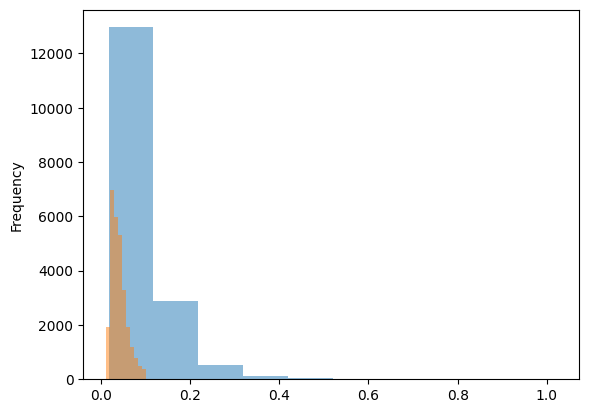

In [106]:
df[df['training_set']==0].Gaia_parallax_err.plot(kind='hist', alpha=0.5);
df[df['training_set']==1].Gaia_parallax_err.plot(kind='hist',  alpha=0.5);

In [127]:
data_dir = "/data/jdli/sdss/"

np.save(data_dir+"hogg19_spec_nnnorm_tr.npy", normspecDict_trlst)
np.save(data_dir+"hogg19_spec_nnnorm_val.npy", normspecDict_vallst)



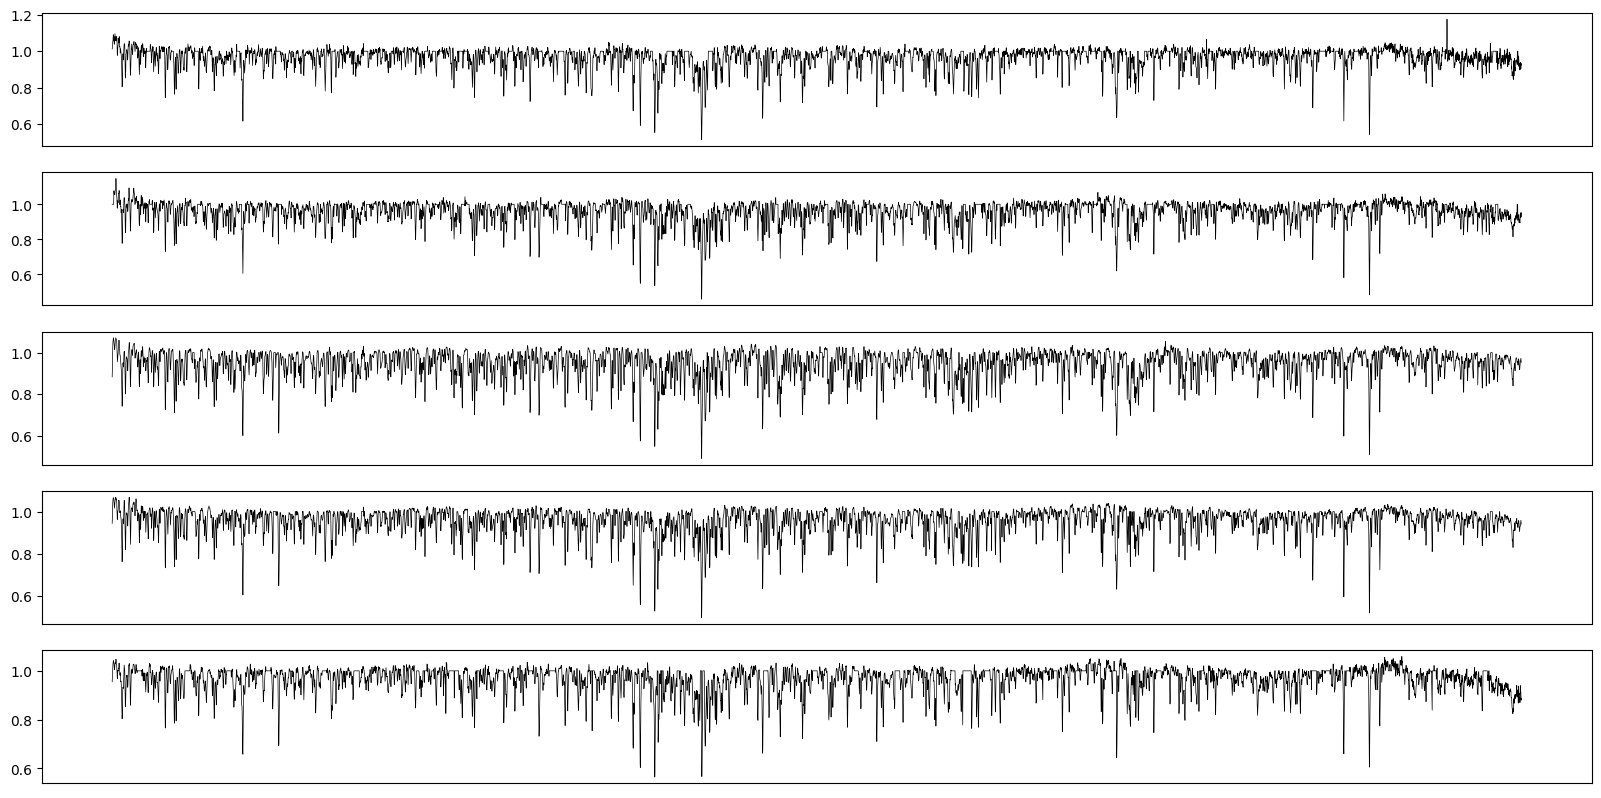

In [126]:
idx_lst = [0, 10, 100, 1000, 10000]
fig, axs = plt.subplots(len(idx_lst), 1, figsize=(20, 2*len(idx_lst)))

for i,idx in enumerate(idx_lst):
    axs[i].plot(
        np.arange(normspecDict_trlst[idx]['norm_spec'].shape[1]), 
        normspecDict_trlst[idx]['norm_spec'].T, lw=0.5, c='k')
    axs[i].set_xticks([]);


In [ ]:
# def read_aspcapStar_tr(fname, cat=cat):
#     spec_dic = read_aspcapStar(fname)
#     match = cat['2MASS_ID']==spec_dic['tmass_id']
    
#     prlx, e_prlx = cat[match]['Gaia_parallax'].data[0], cat[match]['Gaia_parallax_err'].data[0]
#     tr = cat[match]['training_set'].data[0]
    
#     prlx_hogg, e_prlx_hogg = cat[match]['spec_parallax'].data[0], cat[match]['spec_parallax_err'].data[0]
    
#     spec_dic.update({'Gaia_parallax':prlx, 'Gaia_parallax_err':e_prlx, 'training_set':tr, 
#                      'spec_parallax':prlx_hogg, 'spec_parallax_err':e_prlx_hogg})
#     return spec_dic